# Classification of bisulfite sequencing reads

Through FACS sorting followed by bisulfite sequencing, we can estimate the methylation patterns for very high-level cell types of the brain: excitatory neurons, glial cells, PV<sup>+</sup> inhibitory neurons, etc. If we then 

### Model of DNA methylation for a purified/isolated cell type:

Let $p_n$ be the probability of having methylation at position $n$ in the genome; we assume $N$ sites that are eligible for methylation, $n = 1 ... N$. Let $x_{n,m}$ be the observed methylation at position $n$ on read $m$

$$x_{n,m} = \left\{\begin{matrix} 1~,\hspace{22px}\text{if methylated} \\ 0~,~\text{not methylated}  \end{matrix}\right.$$

Each read is much shorter than the entire genome, so we have to figure out how to deal with missing data. 

$$x_{n,m} = \left\{\begin{matrix} 1~,\hspace{40px}\text{if methylated}\hspace{40px} \\ 0~,\hspace{35px}\text{not methylated}\hspace{35px} \\ *~,~\text{position $n$ not in read $m$} \end{matrix}\right.$$

I'm not 100% sure the best way to deal with missing data yet (see "data imputation" below). In principle, the next step would be to do a logistic regression, using the observed methylations to the left/right of position $i$ to predict the probability of methylation:

$$ \ln \left( \frac{\hat{p}_i}{1 - \hat{p}_i} \right) = \beta_0 + \beta_1 x_{i+1} + \beta_{-1} x_{i-1} + \beta_2 x_{i+2} + \beta_{-2} x_{i-2} + ...$$

The above equation models our estimate of $p_i$ given a single read that contains a $0$ or $1$ for $x_{i,m}$ (we omit the $m$ since it is the same for all variables). More compactly,

$$ \ln \left( \frac{\hat{p}_i}{1 - \hat{p}_i} \right) = \beta_0 + \boldsymbol{\beta}_+ \mathbf{x}_{i+} + \boldsymbol{\beta}_- \mathbf{x}_{i-}$$

Where $\boldsymbol{\beta}_+ = [\beta_1, \beta_2, ..., \beta_k]^T$ are parameters for $\mathbf{x}_{i+} = [x_{i+1}, x_{i+2}, ..., x_{i+k}]^T$ and $\boldsymbol{\beta}_- = [\beta_{-1}, \beta_{-2}, ..., \beta_{-k}]^T$ are parameters for $\mathbf{x}_{i-} = [x_{i-1}, x_{i-2}, ..., x_{i-k}]^T$. This can be thought of as an autoregressive model of order $k$ in both directions from methylation site $i$.


### Extension to multiple cell types or clusters

If we have a mixed sample with multiple cell types (clusters), then we can model the probability of methylation at each site with a mixture of the logistic models described above. Suppose we have $C$ different cell types:

$$ \ln \left( \frac{\hat{p}_i}{1 - \hat{p}_i} \right) = \left\{\begin{matrix}
\beta_0^1 + \boldsymbol{\beta}_+^1 \mathbf{x}_{i+} + \boldsymbol{\beta}_{-}^1 \mathbf{x}_{i-}
\hspace{20px},\hspace{8px}\text{with probability } \pi_1 \\
\beta_0^2 + \boldsymbol{\beta}_+^2 \mathbf{x}_{i+} + \boldsymbol{\beta}_{-}^2 \mathbf{x}_{i-}
\hspace{20px},\hspace{8px}\text{with probability } \pi_2 \\
... \\
\beta_0^C + \boldsymbol{\beta}_+^C \mathbf{x}_{i+} + \boldsymbol{\beta}_{-}^C \mathbf{x}_{i-}
\hspace{20px},\hspace{8px}\text{with probability } \pi_C \end{matrix}\right.$$

With $\boldsymbol{\pi} = [\pi_1, \pi_2, ..., \pi_C]^T$ being the proportions of each cell type in the sample, $\sum_c \pi_c = 1$.

[Fariaa & Soromenhob (2010)](http://www.researchgate.net/profile/S_Faria/publication/228464588_Fitting_mixtures_of_linear_regressions/links/00b49519b60d62e512000000.pdf) describe and compare methods for fitting mixtures of linear regression models. There is a library called [FlexMix](http://cran.r-project.org/web/packages/flexmix/vignettes/flexmix-intro.pdf) in R that implements some of these algorithms. Also see [these lecture slides](https://stat.duke.edu/courses/Fall08/sta216/lecture13.pdf).

### Assigning Reads to Clusters

Using the logistic regression, we have a list of methylation probabilities for at each position $i$ in each cluster $c$, which we denote $\hat{p}_{i,c}$. Calculate the likelihood that each read belongs to each cluster, and re-assign it to the most likely cluster.

#### Likelihood of read $m$ belonging to cluster $c$:

$$L(\mathbf{x}_m) = \prod_{n \in \mathcal{R_m}} \hat{p}_{n,c} x_{n,m} $$

### Algorithm

* Randomly assign reads to clusters
* Initialize data imputation (see below)
* Expectation Maximization. Iterate:
    * Fit GLM for each position within each cluster
        * This is computationally expensive, but embarassingly parallel
        * Maybe limit analysis to portion of genome if too expensive
    * Re-assign reads to clusters in a greedy fashion
        * How to do this?
    * Recalculate data imputation based on new clusters

### Data Imputation Options (how to set $x_{n,m}$ when missing data)

* Multiple Imputation: fit model with both a 0 and 1
    * Could become very computationally expensive. Need to fit $2^n$ models, to exhaustively search.
* Bayesian Approach:
    * Assign a beta prior distribution for $p(x_n)$ within each cluster
    * Calculate posterior distribution, $p(x_n|\{x_{n,c}|\forall c \in \mathcal{C}\})$
        * $\mathcal{C}$ is the set of all reads in the same cluster as $m$ that have data at position $n$
        * This is a beta-binomial distribution
    * Fit logistic model multiple times, drawing missing values from the above distribution.
* Point-estimates (probably more efficient):
    * Set $x_{n,m}$ to $\frac{1}{M}\sum_{m=1}^M x_{n,m}$ (mean across all data)
    * Set $x_{n,m}$ to the cluster mean at position $n$
    
### Concerns

* Clusters are of different sizes (some cell types much more common than others).
    * http://www-users.cs.umn.edu/~kumar/papers/kdd02_snn_28.pdf
* Computational tractability
    * If we fit a different mixture of models to predict the probability of methylation at each eligible position, this could take a lot of compute time. However, it is embarassingly parallel, so access to a cluster *might* make this plausible.

In [1]:
using Distributions
include("methylation_functions.jl");

INFO: Loading help data...


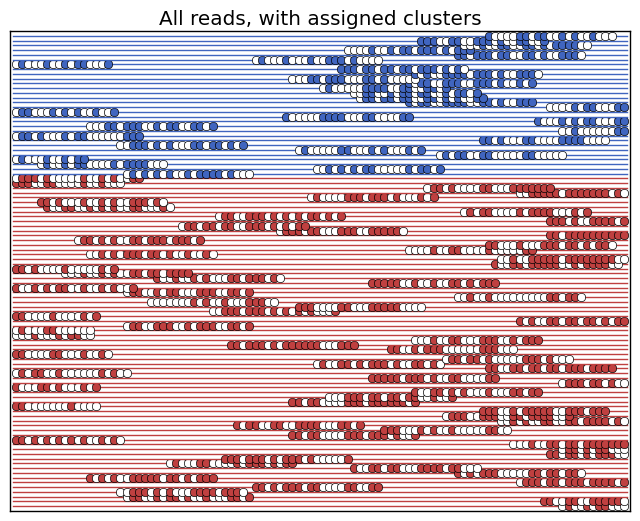

PyObject <matplotlib.text.Text object at 0x7f4ae57a5590>

In [2]:
X,P,c = generate_reads()
plot_meth(X,c)

* classification
* matrix factorization/completion
    * Netflix problem

In [3]:
X,P,true_c = generate_reads(N=1000);
Xpad = deepcopy(X)
nc = 2 # number of clusters
c = rand(1:nc,size(X,1)) # initial cluster assignments

for i = 1:size(X,2)
    is_nan = isnan(X[:,i])
    not_nan = !isnan(X[:,i])
    Xpad[is_nan,i] = mean(X[not_nan,i])
end

In [4]:
using GLM
K = 5  # order of autoregression
N,L = size(X)

models = {}
for i = 1:nc
    X_c = Xpad[c.==i,:] # reads assigned to cluster i
    for j = 1:L
        # Predicted variable (probability of methylation at site j)
        reads = !isnan(X_c[:,j])
        Y = X_c[reads,j]
        
        # Independent variables (observed methylation at nearby sites)
        s1 = maximum([1,j-K])
        s2 = minimum([L,j+K])
        Xpred = hcat(X_c[reads,s1:j-1],X_c[reads,j+1:s2])
        
        # Fit a logistic regression -- intercept is included by default
        model = glm(Xpred,Y,Binomial(),LogitLink())
        push!(models,model)
        
#         while !done
#             try
#                 model = glm(Xpred,Y,Binomial(),LogitLink())
#                 push!(models,model)
#                 done = true
#             catch
#                 # Shrink independent variables
#                 println("!!!!")
#                 s1 += 1
#                 s2 -= 1
#                 Xpred = hcat(X_c[reads,s1:i-1],X_c[reads,i+1:s2])
#                 if s1 == i
#                     println("stop")
#                     break
#                 end
#             end
#         end 
    end
end

In [5]:
names(models[10])

3-element Array{Symbol,1}:
 :rr 
 :pp 
 :fit

In [6]:
models[10]

GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial,LogitLink},DensePredChol{Float64,Cholesky{Float64}}}:

Coefficients:
       Estimate Std.Error   z value Pr(>|z|)
x1     0.617186  0.745202  0.828213   0.4075
x2      0.93165  0.577296   1.61382   0.1066
x3     -2.07068    1.1324  -1.82858   0.0675
x4    -0.521557  0.598076 -0.872058   0.3832
x5   0.00870235   0.57452 0.0151472   0.9879
x6    0.0475383   0.55329 0.0859193   0.9315
x7      2.29652  0.914372   2.51159   0.0120
x8    0.0977618  0.627127  0.155888   0.8761
x9     -1.23111  0.954307  -1.29005   0.1970
x10   -0.224667  0.765803 -0.293375   0.7692



In [7]:
models[10].pp.beta0

10-element Array{Float64,1}:
  0.617186  
  0.93165   
 -2.07068   
 -0.521557  
  0.00870235
  0.0475383 
  2.29652   
  0.0977618 
 -1.23111   
 -0.224667  